In [138]:
import torch
import torchvision
import sklearn.metrics as metrics
import numpy as np
import sys
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime
from helper import get_cat_count, count_parameters, compute_confusion_matrix, show_examples, plot_training_loss, plot_accuracy, plot_confusion_matrix

# COMP9444 Assignment 2

## Cat breed classification

## Neural Network

**student.py**

UNSW COMP9444 Neural Networks and Deep Learning

You may modify this file however you wish, including creating additional
variables, functions, classes, etc., so long as your code runs with the
hw2main.py file unmodified, and you are only using the approved packages.

You have been given some default values for the variables train_val_split,
batch_size as well as the transform function.
You are encouraged to modify these to improve the performance of your model.

**Answer to Question:**

Briefly describe how your program works, and explain any design and training
decisions you made along the way.

In [139]:
############################################################################
######     Specify transform(s) to be applied to the input images     ######
############################################################################

def transform(mode):
    """
    Called when loading the data. Visit this URL for more information:
    https://pytorch.org/vision/stable/transforms.html
    You may specify different transforms for training and testing
    """

    # channel size = 3

    if mode == 'train':
        return transforms.Compose(
            [   
                # transforms.RandomCrop((64, 64)),
                transforms.RandomResizedCrop(size=80, 
                         scale=(0.75, 1.0), ratio=(0.75, 1.3)), # original 80*80, avoid cropping important info
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation((-10,10)),
                transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.3, hue=0.2),
                transforms.RandomPosterize(bits=3, p=0.4),
                transforms.RandomEqualize(p=0.1),
                transforms.RandomGrayscale(p=0.1),
                transforms.RandomPerspective(distortion_scale=0.05, p=0.1, fill=0),
                ## T.RandomErasing(),
                ## T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                ## T.RandomInvert(p=0.05),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
    elif mode == 'test':
        return transforms.Compose(
            [   
                # transforms.CenterCrop((64, 64)),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## transforms.Normalize([0.485, 0.456, 0.406],
                ##                                 [0.229, 0.224, 0.225]),
            ]
        )

In [146]:
#################################################################################
#####                      Specify NN to be used                           ######
#################################################################################

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 30, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(30, 120, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(120, 360, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(360, 540, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(540*3*3, 4096),
            nn.ReLU(),
            
            nn.Dropout(p=0.4),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            
            nn.Dropout(p=0.4),
            nn.Linear(4096, 8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)    
    

####################################################################################################################
# Re-implementation of AlexNet                                                                                     #
# https://github.com/pytorch/vision/blob/693829121bdc3e26714691f70241c6c01a089457/torchvision/models/alexnet.py    #
####################################################################################################################
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional Layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True), # saves memory
            nn.MaxPool2d((3, 3), stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((3, 3), stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2)
        )
        
        # shrink final conv layer width to 6
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        # fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x
    
        
net = SimpleCNN()

############################################################################
######      Specify the optimizer and loss function                   ######
############################################################################
learning_rate = 0.001
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# loss_func = F.nll_loss
loss_func = nn.CrossEntropyLoss()

############################################################################
######  Custom weight initialization and lr scheduling are optional   ######
############################################################################

# Normally, the default weight initialization and fixed learing rate
# should work fine. But, we have made it possible for you to define
# your own custom weight initialization and lr scheduler, if you wish.
def weights_init(m):
    return

scheduler = None


############################################################################
#######              Metaparameters and training options              ######
############################################################################
dataset = "./data"
train_val_split = 0.8
batch_size = 200
epochs = 250

### Plotting Helper functions

## HW 2 Main

In [148]:
# Use a GPU if available, as it should be faster.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

###########################
## Cat breed dictionary  ##
###########################
cat_dict = {
    0: 'Bombay',
    1: 'Calico',
    2: 'Persian',
    3: 'RussianBlue',
    4: 'Siamese',
    5: 'Tiger',
    6: 'TortoiseShell',
    7: 'Tuxedo'
}

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


# Test network on validation set, if it exists.
## Added params
def test_network(net,testloader,test_accuracy_list,print_confusion=False):
    net.eval()
    total_images = 0
    total_correct = 0
    conf_matrix = np.zeros((8,8))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                labels.cpu(),predicted.cpu(),labels=[0,1,2,3,4,5,6,7])

    model_accuracy = total_correct / total_images * 100
    test_accuracy_list.append(model_accuracy)
    print(', {0} test {1:.2f}%'.format(total_images,model_accuracy))
    if print_confusion:
        np.set_printoptions(precision=2, suppress=True)
        print(conf_matrix)
    net.train()

In [149]:
##############################
### Tracking training time ###
##############################
start_time = time.time() ## Added
time_elapsed = 0  ## Added Line
##############################

###############################
### Tracking nn performance ###
###############################
minibatch_loss_list, train_accuracy_list, test_accuracy_list = [], [], [] ## Added
###############################



# Main
print("Using device: {}"
      "\n".format(str(device)))
########################################################################
#######                      Loading Data                        #######
########################################################################
data = torchvision.datasets.ImageFolder(root=dataset)

if train_val_split == 1:
    # Train on the entire dataset
    data = torchvision.datasets.ImageFolder(root=dataset,
                        transform=transform('train'))
    trainloader = torch.utils.data.DataLoader(data,
                        batch_size=batch_size, shuffle=True);
else:
    # Split the dataset into trainset and testset
    data = torchvision.datasets.ImageFolder(root=dataset)
    data.len=len(data)
    train_len = int((train_val_split)*data.len)
    test_len = data.len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    trainset = DatasetFromSubset(
        train_subset, transform=transform('train'))
    testset = DatasetFromSubset(
        test_subset, transform=transform('test'))

    trainloader = torch.utils.data.DataLoader(trainset, 
                        batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, 
                        batch_size=batch_size, shuffle=False)


# Get model, loss criterion and optimizer from student
net = net.to(device)
criterion = loss_func
optimizer = optimizer
# get weight initialization and lr scheduler, if appropriate
weights_init = weights_init
scheduler = scheduler

# apply custom weight initialization, if it exists
net.apply(weights_init)

########################################################################
#######                        Training                          #######
########################################################################
print("Start training...")
for epoch in range(1,epochs+1):
    total_loss = 0
    total_images = 0
    total_correct = 0

    for batch in trainloader:           # Load batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images)             # Process batch

        loss = criterion(preds, labels) # Calculate loss

        optimizer.zero_grad()
        loss.backward()                 # Calculate gradients
        optimizer.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_images += labels.size(0)
        total_correct += output.eq(labels).sum().item()
        minibatch_loss_list.append(loss.item())  ## Added

    # apply lr schedule, if it exists
    if scheduler is not None:
        scheduler.step()

    model_accuracy = total_correct / total_images * 100 
    train_accuracy_list.append(model_accuracy)  ## Added
    print('ep {0}, loss: {1:.2f}, {2} train {3:.2f}%'.format(
           epoch, total_loss, total_images, model_accuracy), end='')

    if train_val_split < 1:
        test_network(net,testloader, test_accuracy_list,
                     print_confusion=(epoch % 10 == 0)) ## Added
    else:
        print()
    
    time_elapsed = time.time() - start_time  ## Added Line
    print(f'Time elapsed: {str(datetime.timedelta(seconds = time_elapsed))}') ## Added
    
    if epoch % 10 == 0:
        torch.save(net.state_dict(),'checkModel.pth')
        print("   Model saved to checkModel.pth")        

    sys.stdout.flush()

time_elapsed = time.time() - start_time ## Added Line
print(f'total time needed to train network: {str(datetime.timedelta(seconds = time_elapsed))}\ntotal time in seconds: {time_elapsed}') ## Added Line
torch.save(net.state_dict(),'savedModel.pth')
print("   Model saved to savedModel.pth")



Using device: cuda:0

Start training...
ep 1, loss: 63.99, 6400 train 18.59%, 1600 test 27.25%
Time elapsed: 0:00:19.225005
ep 2, loss: 59.02, 6400 train 26.39%, 1600 test 30.00%
Time elapsed: 0:00:39.624297
ep 3, loss: 56.05, 6400 train 30.94%, 1600 test 37.31%
Time elapsed: 0:01:00.691242
ep 4, loss: 54.66, 6400 train 32.75%, 1600 test 40.50%
Time elapsed: 0:01:19.787041
ep 5, loss: 53.00, 6400 train 35.94%, 1600 test 43.94%
Time elapsed: 0:01:34.431957
ep 6, loss: 52.12, 6400 train 37.17%, 1600 test 47.69%
Time elapsed: 0:01:49.176636
ep 7, loss: 50.70, 6400 train 40.12%, 1600 test 47.75%
Time elapsed: 0:02:03.775353
ep 8, loss: 49.40, 6400 train 41.38%, 1600 test 48.94%
Time elapsed: 0:02:18.402043
ep 9, loss: 47.92, 6400 train 43.94%, 1600 test 50.69%
Time elapsed: 0:02:33.008614
ep 10, loss: 46.63, 6400 train 45.73%, 1600 test 53.06%
[[114.   0.   0.   9.   3.   6.  47.  19.]
 [  0. 101.   4.   0.  26.  33.  26.   9.]
 [  9.  24.  53.  13.  42.  34.  16.   4.]
 [ 11.   9.   6.  7

ep 70, loss: 22.87, 6400 train 75.39%, 1600 test 69.69%
[[158.   2.   0.  11.   1.   2.  13.  11.]
 [  0. 107.   8.   3.  17.  34.  19.  11.]
 [ 10.   4.  99.  15.  26.  25.  10.   6.]
 [ 15.   1.   6. 127.   4.  14.   9.   8.]
 [  1.  16.  17.   9. 144.  10.   6.   4.]
 [  0.   4.   1.   8.   0. 191.   3.   2.]
 [ 18.   4.   3.   8.   0.  30. 131.   5.]
 [ 11.  14.   4.   6.   2.   4.  10. 158.]]
Time elapsed: 0:17:28.868335
   Model saved to checkModel.pth
ep 71, loss: 22.11, 6400 train 75.39%, 1600 test 71.25%
Time elapsed: 0:17:43.770012
ep 72, loss: 21.56, 6400 train 75.98%, 1600 test 71.69%
Time elapsed: 0:17:58.375203
ep 73, loss: 21.67, 6400 train 76.50%, 1600 test 70.50%
Time elapsed: 0:18:13.020817
ep 74, loss: 21.36, 6400 train 76.45%, 1600 test 70.88%
Time elapsed: 0:18:28.205030
ep 75, loss: 21.43, 6400 train 75.78%, 1600 test 72.19%
Time elapsed: 0:18:43.271536
ep 76, loss: 21.32, 6400 train 76.38%, 1600 test 72.62%
Time elapsed: 0:18:58.047263
ep 77, loss: 22.14, 6400 tr

ep 135, loss: 15.00, 6400 train 84.19%, 1600 test 73.12%
Time elapsed: 0:33:31.898832
ep 136, loss: 16.15, 6400 train 82.22%, 1600 test 71.81%
Time elapsed: 0:33:46.985793
ep 137, loss: 16.59, 6400 train 81.98%, 1600 test 73.19%
Time elapsed: 0:34:01.543788
ep 138, loss: 15.41, 6400 train 83.41%, 1600 test 73.06%
Time elapsed: 0:34:16.109557
ep 139, loss: 15.20, 6400 train 83.89%, 1600 test 73.00%
Time elapsed: 0:34:30.711544
ep 140, loss: 16.57, 6400 train 81.92%, 1600 test 72.94%
[[147.   2.   1.  11.   2.   5.  18.  12.]
 [  0. 133.   3.   4.   9.  28.  13.   9.]
 [  7.   9.  94.  15.  28.  23.  14.   5.]
 [  6.   5.   1. 147.   1.   9.  10.   5.]
 [  1.  27.   8.  10. 145.  10.   2.   4.]
 [  0.   7.   2.   4.   2. 188.   5.   1.]
 [  3.   9.   4.   8.   3.  16. 153.   3.]
 [  5.  22.   4.   6.   3.   1.   8. 160.]]
Time elapsed: 0:34:45.272815
   Model saved to checkModel.pth
ep 141, loss: 16.84, 6400 train 82.11%, 1600 test 72.12%
Time elapsed: 0:35:00.108227
ep 142, loss: 15.94,

   Model saved to checkModel.pth
ep 201, loss: 13.15, 6400 train 86.42%, 1600 test 71.12%
Time elapsed: 0:49:37.857502
ep 202, loss: 12.33, 6400 train 86.67%, 1600 test 73.00%
Time elapsed: 0:49:52.436296
ep 203, loss: 12.01, 6400 train 87.80%, 1600 test 72.12%
Time elapsed: 0:50:07.016907
ep 204, loss: 12.69, 6400 train 87.06%, 1600 test 72.81%
Time elapsed: 0:50:21.555423
ep 205, loss: 13.14, 6400 train 86.11%, 1600 test 72.81%
Time elapsed: 0:50:36.109326
ep 206, loss: 13.21, 6400 train 85.88%, 1600 test 72.00%
Time elapsed: 0:50:50.684005
ep 207, loss: 12.53, 6400 train 86.97%, 1600 test 73.25%
Time elapsed: 0:51:05.269067
ep 208, loss: 12.66, 6400 train 86.31%, 1600 test 71.44%
Time elapsed: 0:51:19.879175
ep 209, loss: 12.46, 6400 train 86.77%, 1600 test 72.56%
Time elapsed: 0:51:34.444841
ep 210, loss: 12.65, 6400 train 86.83%, 1600 test 73.56%
[[166.   1.   1.   8.   1.   2.   7.  12.]
 [  0. 121.   7.   8.  16.  13.  13.  21.]
 [  8.  10. 107.  15.  19.  15.  13.   8.]
 [ 13. 

### Analysis

Compose(
    RandomResizedCrop(size=(80, 80), scale=(0.75, 1.0), ratio=(0.75, 1.3), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.2, 0.2])
    RandomPosterize(bits=3,p=0.4)
    RandomEqualize(p=0.1)
    RandomGrayscale(p=0.1)
    RandomPerspective(p=0.1)
    ToTensor()
)
SimpleCNN(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(30, 120, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(120, 360, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilat

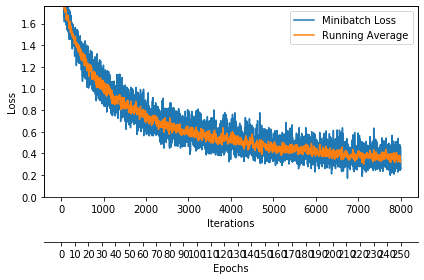

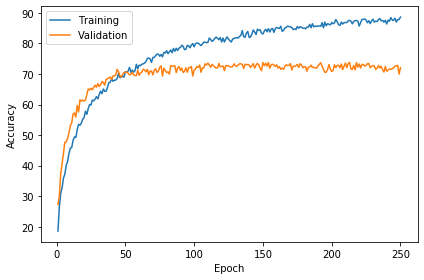

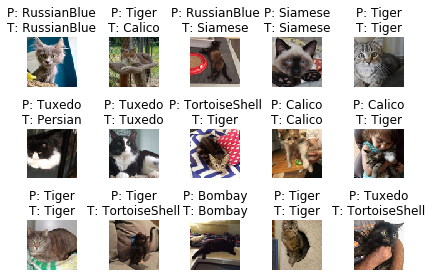

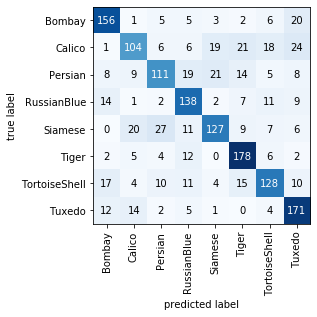

In [150]:
###################################
#**       Network Information   **#
###################################
print(transform('train'))
print(net)
count_parameters(net)


###################################
#**        Data Information     **#
###################################
print(f'batch size: {batch_size}')
print(f'learning rate: {learning_rate}')
print(f'train_val_split: {train_val_split}')
print(f'epochs: {epochs}')


#############################
#**         END           **#
#############################


# Getting count of each cat breed, should be close to 8*0.8*1000 initially..
train_data_distribution = get_cat_count(trainloader, 'training data')
# Getting count of each cat breed, should be close to 8*0.2*1000 initially..
test_data_distribution = get_cat_count(testloader, 'test data')

print(f'training data distribution - {train_data_distribution}')
print(f'test data distribution - {test_data_distribution}')

print(f'shape of image: ')
print(Xs[0].shape)


plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=epochs,
                   iter_per_epoch=len(trainloader),
                   results_dir=None,
                   averaging_iterations=10)
plt.show()


plot_accuracy(train_acc_list=train_accuracy_list,
              test_acc_list=test_accuracy_list,
              results_dir=None)
plt.show()

net.cpu()
show_examples(model=net, data_loader=testloader, class_dict=cat_dict)

conf_matrix = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))

plot_confusion_matrix(conf_matrix, class_names=cat_dict.values())
plt.show()